In [18]:
import nltk
from nltk.stem.porter import PorterStemmer
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime
import json
from tools import stem,puncremover_lower,bag_of_words,tokenize
from model import NeuralNet

In [19]:
with open('../dataset/dataset.json','r') as json_file:
        json_dataset=json.load(json_file)

In [20]:
all_words=[]
tokens=[]
maping=[]

In [21]:
for item in json_dataset['items']:
    token=item['keys']
    if token not in tokens:
        tokens.append(token)
    for question in item['questions']:
        sentence=puncremover_lower(sentence=question)
        words=tokenize(sentence=sentence)
        all_words.extend(words)
        maping.append((words,token))
all_words=[stem(word=word) for word in all_words]
all_words=sorted(set(all_words))
tokens=sorted(set(tokens))

In [22]:
x_train=[]
y_train=[]

In [23]:
for (words,token) in maping:
    bag=bag_of_words(tokenize_sentence=words,all_words=all_words)
    x_train.append(bag)
    label=tokens.index(token)
    y_train.append(label)
x_train=np.array(x_train)
y_train=np.array(y_train)

In [24]:
class class_dataset(Dataset):
    def __init__(self):
        self.num_samples=len(x_train)
        self.x_data=x_train
        self.y_data=y_train
    def __getitem__(self, index):
        return self.x_data[index],self.y_data[index]
    def __len__(self):
        return self.num_samples

In [25]:
batch_size=8
hidden_size=8
input_size=len(all_words)
output_size=len(tokens)
learning_rate=0.001
num_epochs=2000

In [26]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset=class_dataset()
train_loader=DataLoader(dataset=dataset,batch_size=8,shuffle=True,num_workers=0)
model=NeuralNet(input_size=input_size,hidden_size=hidden_size,num_classes=output_size).to(device=device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [27]:
final_loss = []
final_accuracy = []
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    array_loss=0
    for (words, labs) in train_loader:
        words = words.to(device)
        labs = labs.to(device)
        labs = labs.long()
        output = model(words)
        loss = criterion(output, labs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        array_loss=loss
        _, predicted = torch.max(output, 1)
        total_correct += torch.sum(predicted==labs).item()
        total_samples += labs.size(0)
    array_accuracy = 100 * float(total_correct) / float(total_samples)
    print(f"Epoch: {epoch+1}/{num_epochs} [=========================>] Loss: {array_loss:.4f} [=========================>] Accuracy: {array_accuracy:.4f}")
    final_loss.append(float(array_loss))
    final_accuracy.append(array_accuracy)
print(f"Final Result: {num_epochs} [=========================>] Loss: {final_loss[-1]:.4f} [=========================>] Accuracy: {final_accuracy[-1]:.4f}")

Epoch: 1/2000 [=========================>] Loss: 2.3573 [=========================>] Accuracy: 6.5574
Epoch: 2/2000 [=========================>] Loss: 2.3452 [=========================>] Accuracy: 6.5574
Epoch: 3/2000 [=========================>] Loss: 2.2860 [=========================>] Accuracy: 6.5574
Epoch: 4/2000 [=========================>] Loss: 2.4751 [=========================>] Accuracy: 6.5574
Epoch: 5/2000 [=========================>] Loss: 2.4054 [=========================>] Accuracy: 6.5574
Epoch: 6/2000 [=========================>] Loss: 2.2937 [=========================>] Accuracy: 6.5574
Epoch: 7/2000 [=========================>] Loss: 2.4510 [=========================>] Accuracy: 6.5574
Epoch: 8/2000 [=========================>] Loss: 2.2895 [=========================>] Accuracy: 6.5574
Epoch: 9/2000 [=========================>] Loss: 2.1392 [=========================>] Accuracy: 8.1967
Epoch: 10/2000 [=========================>] Loss: 2.2397 [========================

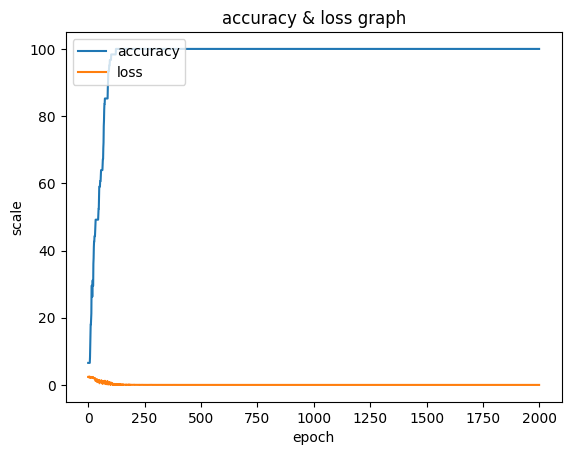

In [28]:
plt.plot(final_accuracy)
plt.plot(final_loss)
plt.title('accuracy & loss graph')
plt.ylabel('scale')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [29]:
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tokens
}

In [30]:
FILE="data.pth"
torch.save(data,FILE)
print(f'training complete. file saved to {FILE}')

training complete. file saved to data.pth
